In [673]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import random
import os

from itertools import combinations

import chinese_calendar as calendar
from chinese_calendar import is_workday, is_holiday
import decimal
from  decimal import Decimal
from datetime import datetime
from datetime import timedelta
import pinyin.cedict
import lightgbm as lgb

import re
import string

In [90]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3') 
pd.set_option('display.max_rows', 30)

In [369]:
path2 = 'D:\\jupyter_lab_files\\titanic\\'
train = pd.read_csv(path2+'train.csv',header = 0,low_memory=False)
test = pd.read_csv(path2+'test.csv',header = 0,low_memory=False)
all_data = pd.concat([train, test], sort=True)
all_data.reset_index(drop=True,inplace = True)

### 1. data analysis

In [370]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [371]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [372]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 2. data processing

In [373]:
fe_corr = all_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
fe_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
fe_corr[fe_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [374]:
all_data.groupby(['Sex', 'Pclass'])['Age'].median()

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [375]:
# using sex and pclass to fill the missing values of ages
all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [376]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [377]:
all_data.loc[all_data['Pclass'] == 1, 'Embarked'].value_counts()

S    177
C    141
Q      3
Name: Embarked, dtype: int64

In [378]:
all_data['Embarked'] = all_data['Embarked'].fillna('S')

In [379]:
all_data.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [380]:
fe_corr[fe_corr['Feature 1'] == 'Fare']

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
7,Fare,Pclass,0.558629
16,Fare,Survived,0.257307
20,Fare,Parch,0.221539
21,Fare,Age,0.178740
23,Fare,SibSp,0.160238
40,Fare,PassengerId,0.031428


In [381]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [382]:
fare_na = all_data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
all_data['Fare'] = all_data['Fare'].fillna(fare_na)

In [383]:
all_data.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [384]:
all_data.loc[all_data['Cabin'].notnull(), 'Cabin'] = all_data.loc[all_data['Cabin'].notnull(), 'Cabin'].apply(lambda s: s[0]) 

In [385]:
all_data['Cabin'].value_counts(dropna = False)

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

In [386]:
all_data['Cabin'].fillna('N', inplace = True)

In [387]:
all_data.groupby(['Cabin', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'PassengerId', 
                                                                        'Ticket']).rename(columns={'Name': 'Count'}).transpose()

Cabin    A   B   C   D      E         F     G   N            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [390]:
all_data['Cabin'] = all_data['Cabin'].replace(['A', 'B', 'C', 'T'], 'ABC')
all_data['Cabin'] = all_data['Cabin'].replace(['D', 'E'], 'DE')
all_data['Cabin'] = all_data['Cabin'].replace(['F', 'G'], 'FG')

In [391]:
all_data.Cabin.value_counts(dropna = False)

N      1014
ABC     182
DE       87
FG       26
Name: Cabin, dtype: int64

### 3. FE

In [395]:
def ticket_chage(tick):
    if not tick.isdigit():
        return tick.replace(".","").replace("/","").strip().split(" ")[0]
    else:
        return 'N'

all_data['Ticket'] = all_data['Ticket'].apply(ticket_chage)

In [593]:
all_data['title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [592]:
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "the Countess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}

In [594]:
all_data['title'] = all_data['title'].map(titleDict)

In [414]:
# 分为已婚，不清楚
all_data['Is_Married'] = 0
all_data.loc[all_data['title'] == 'Mrs','Is_Married'] = 1

In [566]:
def extract_surname(name):    
    
    if '(' in name:
        name = name.split('(')[0] 

    family = name.split(',')[0]
    title = name.split(',')[1].strip().split(' ')[0]
    for i in family:
        if i in string.punctuation:  #如果字符是标点符号的话就将其替换为空
            family = family.replace(i,"")
    family = family.strip()
    return family

In [567]:
all_data['surname'] = all_data['Name'].apply(extract_surname)

Text(0.5, 0, 'Fare')

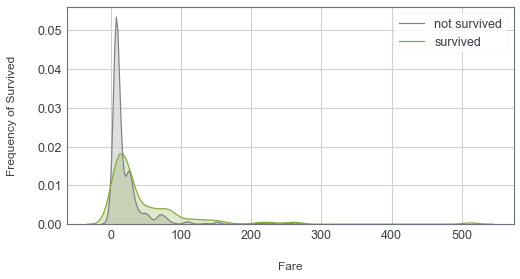

In [568]:
fig = plt.figure(figsize=(8,4),)
ax=sns.kdeplot(all_data.loc[(all_data['Survived'] == 0),'Fare'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(all_data.loc[(all_data['Survived'] == 1),'Fare'] , color='g',shade=True, label='survived')
plt.ylabel("Frequency of Survived", fontsize = 12, labelpad = 20)
plt.xlabel("Fare", fontsize = 12, labelpad = 20)

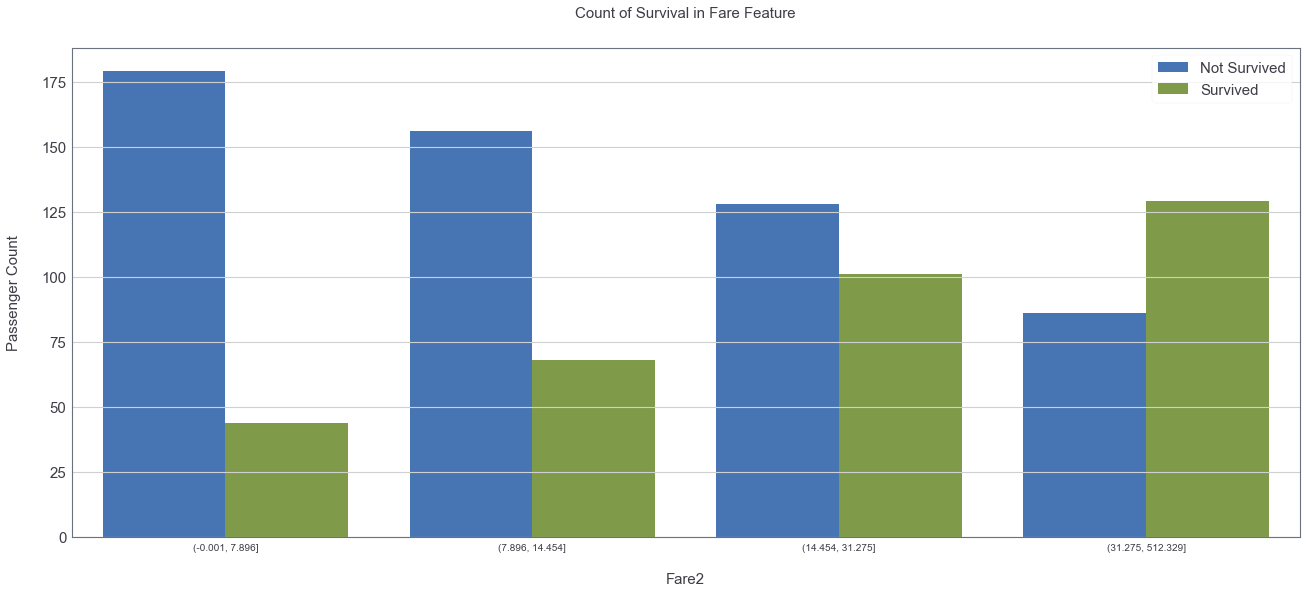

In [569]:
all_data['Fare2'] = pd.qcut(all_data['Fare'], 4)
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare2', hue='Survived', data=all_data)

plt.xlabel('Fare2', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

In [572]:
def fare_category(fare): 
    if fare <= 7.896:
        return 1
    elif fare <= 14.454:
        return 2
    elif fare <= 31.275:
        return 3
    else:
        return 4

all_data['Fare2'] = all_data['Fare'].apply(fare_category)

Text(0.5, 0, 'Age')

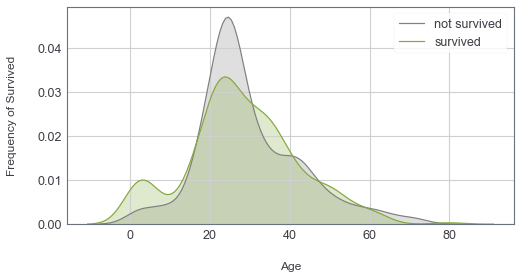

In [575]:
fig = plt.figure(figsize=(8,4),)
ax=sns.kdeplot(all_data.loc[(all_data['Survived'] == 0),'Age'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(all_data.loc[(all_data['Survived'] == 1),'Age'] , color='g',shade=True, label='survived')
plt.ylabel("Frequency of Survived", fontsize = 12, labelpad = 20)
plt.xlabel("Age", fontsize = 12, labelpad = 20)

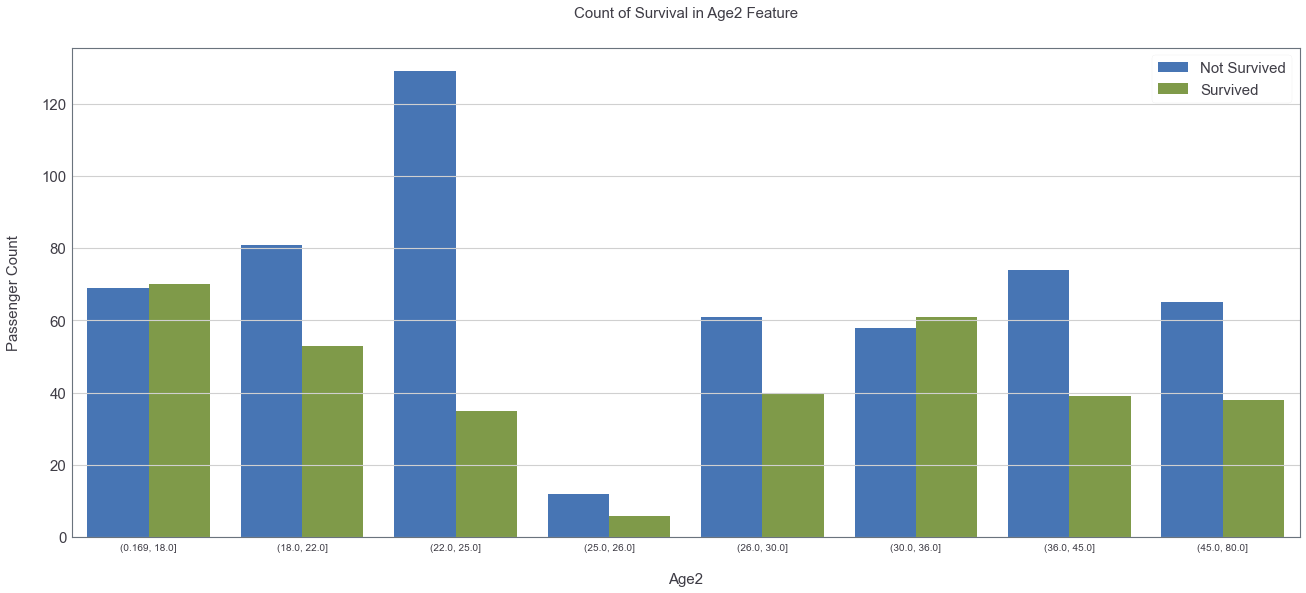

In [578]:
all_data['Age2'] = pd.qcut(all_data['Age'], 8)
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age2', hue='Survived', data=all_data)

plt.xlabel('Age2', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Age2'), size=15, y=1.05)

plt.show()

In [582]:
def Age_category(Age): 
    if Age <= 18:
        return 1
    elif Age <= 22:
        return 2
    elif Age <= 25:
        return 3
    elif Age <= 26:
        return 4
    elif Age <= 30:
        return 5
    elif Age <= 36:
        return 6
    elif Age <= 45:
        return 7
    else:
        return 8

all_data['Age2'] = all_data['Age'].apply(Age_category)

In [584]:
all_data['family'] = all_data['SibSp'] + all_data['Parch'] + 1

In [597]:
all1 = all_data.copy()
all_data = all1.copy()

### Encoding

In [598]:
for col in ['Cabin','Embarked', 'Ticket', 'Sex', 'title','surname']:
    le = LabelEncoder()
    le.fit(all_data[col].value_counts().index.tolist())
    dt = all_data.copy()
    all_data[col] = le.transform(dt[col])

In [601]:
all2 = all_data.copy()

In [611]:
#One hot encoding
category_columns = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Ticket','title','Is_Married','surname',
                    'Fare2','Age2','family']

for feature in category_columns:
    encoded_feat = OneHotEncoder().fit_transform(all_data[feature].values.reshape(-1, 1)).toarray()
    n = all_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = all_data.index
    all_data = pd.concat([all_data, encoded_df], axis=1)

In [613]:
all3 = all_data.copy()

### 4. lgb

In [618]:
all2.drop(['Name', 'PassengerId'], axis = 1, inplace = True)
dtrain = all2.loc[all2['Survived'].notnull()]
dtest = all2.loc[all2['Survived'].isnull()]
dtrain.reset_index(drop=True,inplace = True)
dtest.reset_index(drop=True,inplace = True)

train_x = dtrain.drop('Survived', axis = 1)
train_y = dtrain['Survived']
test_x = dtest.drop('Survived', axis = 1)

In [619]:
columns = train_x.columns.tolist()
category_columns = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Ticket','title','Is_Married','surname',
                    'Fare2','Age2','family']

#### 4.1 tuning parameters

In [631]:
gridParams = {
    'learning_rate': [0.1, 0.05, 0.2],
    'max_depth':[4,6,8],
    'num_leaves': [4,8,16,32],
    'min_child_weight': [1.175, 2], 
    'colsample_bytree' : [0.8, 0.9],
    'subsample' : [0.7,0.8],
    'scale_pos_weight': [1,2,3],
    }


mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True)

# GridSearchCV to tune
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(train_x,train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2, 'num_leaves': 32, 'scale_pos_weight': 1, 'subsample': 0.7}
0.8406556780996243


In [636]:
# A better parameter selection 
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.97,
 'learning_rate': 0.0369,
 'max_depth': 11,
 'min_child_weight': 1.175,
 'num_leaves': 4028,
 'objective': 'binary'}

In [651]:
train_xx, val_x, train_yy, val_y = train_test_split(train_x,train_y,test_size=0.1,stratify=train_y, random_state = 3)
ddtrain = lgb.Dataset(train_xx, label=train_yy)
ddval = lgb.Dataset(val_x, label=val_y)
print('training.....')
clf = lgb.train(params, ddtrain, 10000, feature_name = columns, categorical_feature = category_columns,
                valid_sets = [ddtrain,ddval], verbose_eval=100,early_stopping_rounds=300) 

# joblib.dump(clf, date.strftime('%Y%m%d') + "_model.m")
# print('模型保存成功')
val_pred = clf.predict(val_x, num_iteration=clf.best_iteration)
print('验证集auc：',roc_auc_score(val_y, val_pred))

training.....
Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.267768	valid_1's binary_logloss: 0.335776
[200]	training's binary_logloss: 0.186388	valid_1's binary_logloss: 0.319344

D:\software\programming\anaconda\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Age2', 'Cabin', 'Embarked', 'Fare2', 'Is_Married', 'Pclass', 'Sex', 'Ticket', 'family', 'surname', 'title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[300]	training's binary_logloss: 0.142918	valid_1's binary_logloss: 0.318505
[400]	training's binary_logloss: 0.116356	valid_1's binary_logloss: 0.33228
[500]	training's binary_logloss: 0.0996562	valid_1's binary_logloss: 0.344399
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.160328	valid_1's binary_logloss: 0.311629
验证集auc： 0.932987012987013


In [652]:
fpr, tpr, thresholds = roc_curve(val_y, val_pred, pos_label=1)

In [639]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        

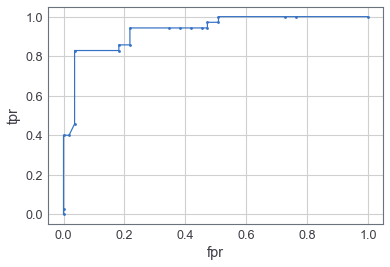

In [653]:
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [654]:
test_pred = clf.predict(test_x, num_iteration=clf.best_iteration)

In [655]:
test['Survived'] = test_pred
submission = test.loc[:,['PassengerId', 'Survived']].copy()

submission.loc[submission['Survived'] > 0.5,'Survived'] = 1
submission.loc[submission['Survived'] < 1,'Survived'] = 0
submission['Survived'] = submission['Survived'].astype('int')
submission.to_csv('submission.csv', index=False)

In [667]:
submission.Survived.value_counts()

0    261
1    157
Name: Survived, dtype: int64

### 5. Random Forest

In [670]:
all3.drop(['Name', 'PassengerId'], axis = 1, inplace = True)
dttrain = all3.loc[all3['Survived'].notnull()]
dttest = all3.loc[all3['Survived'].isnull()]
dttrain.reset_index(drop=True,inplace = True)
dttest.reset_index(drop=True,inplace = True)

rf_train_x = dttrain.drop('Survived', axis = 1)
rf_train_y = dttrain['Survived']
rf_test_x = dttest.drop('Survived', axis = 1)

In [684]:
rf = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=5,
                                           verbose=1) 

In [685]:
rf_train_xx, val_xx, rf_train_yy, val_yy = train_test_split(rf_train_x,rf_train_y,test_size=0.1,stratify=train_y, 
                                                            random_state = 3)
rf.fit(rf_train_xx, rf_train_yy)
rf_val_pred = rf.predict_proba(val_xx)[:, 1]
rf_fpr, rf_tpr, rf_thresholds = roc_curve(val_y, rf_val_pred, pos_label=1)
print('验证集auc：',roc_auc_score(val_yy, rf_val_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:    1.7s finished


验证集auc： 0.9231168831168831


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:    0.0s finished


In [690]:
test_pred = rf.predict(rf_test_x)
test['Survived'] = test_pred
submission = test.loc[:,['PassengerId', 'Survived']].copy()

submission.loc[submission['Survived'] > 0.5,'Survived'] = 1
submission.loc[submission['Survived'] < 1,'Survived'] = 0
submission['Survived'] = submission['Survived'].astype('int')
submission.to_csv('submission.csv', index=False)
submission.Survived.value_counts()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:    0.1s finished


0    308
1    110
Name: Survived, dtype: int64